In [1]:
%load_ext cython
import pyrost as rst
import speckle_tracking as st
from pyrost.bin import *
from pyrost import simulation as st_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from multiprocessing import cpu_count
from scipy.ndimage import gaussian_filter, uniform_filter, convolve1d
from importlib import reload

pyximport.install(reload_support=True, build_in_temp=False)

(None, <pyximport.pyximport.PyxImporter at 0x7fbad8a07610>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'barcode_profile', 'fft_python', 'gaussian_filter', 'ifft_python', 'irfft_python', 'krig_data', 'least_squares', 'make_reference', 'mse_total', 'np', 'phase_fit', 'pixel_translations', 'rfft_python', 'st', 'st_update', 'str_update', 'update_pixel_map_gs', 'upm_surface']


# ST Simulation

In [3]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, p0 = 5e4, th_s=8e-5, n_frames=200,
                           offset=2.0, step_size=0.1, focus=1500, defocus=1000,
                           alpha=0.05, ab_cnt=0.7, bar_rnd=0.7, ap_x=40, det_dist=2e6)

globals().update(**params.export_dict())
print(params)

{'defocus': 1000.0, 'det_dist': 2000000.0, 'n_frames': 200, 'step_size': 0.1, 'step_rnd': 0.2, 'fs_size': 2000, 'pix_size': 55.0, '...': '...'}


In [4]:
%time sim_obj = st_sim.STSim(params)

CPU times: user 20.5 s, sys: 1.66 s, total: 22.1 s
Wall time: 2.33 s


In [9]:
%time sim_obj = st_sim.STSim(params)
sim_obj = sim_obj.update_bar_positions(0.7 * np.arange(10))
print(sim_obj.bar_pos)

CPU times: user 20.6 s, sys: 1.56 s, total: 22.2 s
Wall time: 2.15 s
[0.  0.7 1.4 2.1 2.8 3.5 4.2 4.9 5.6 6.3]


In [10]:
n_x = params.x_wavefront_size()
n_y = params.y_wavefront_size()
nx_arr = np.arange(-n_x // 2, n_x // 2)
ny_arr = np.arange(-n_y // 2, n_y // 2)
lens_wfx, lens_wfy, dx0, dy0 = params.lens_wavefronts(return_dxdy=True)
print(n_x, n_y)

58527 1508


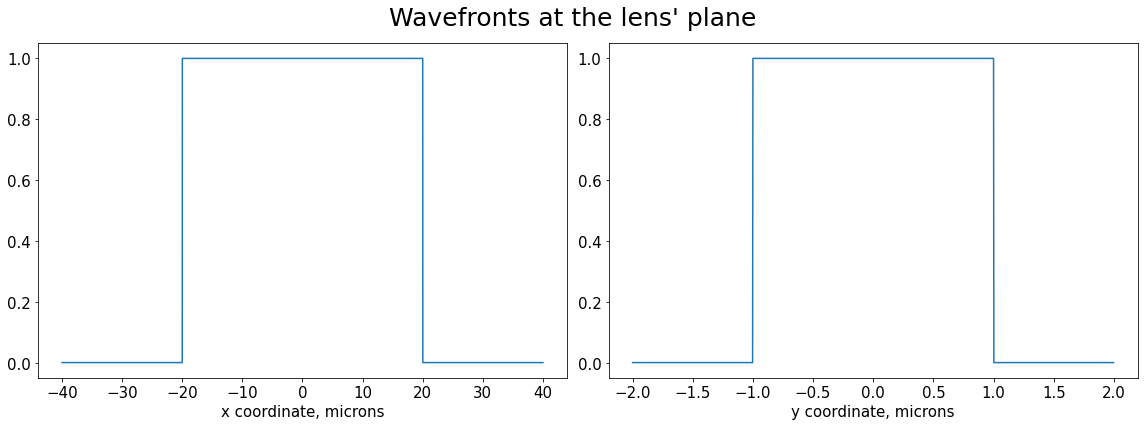

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx0 * nx_arr, np.abs(lens_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy0 * ny_arr, np.abs(lens_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the lens' plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/lens_wf.pdf')

In [12]:
dx1, dy1 = dx0 * defocus / focus, dy0
z01 = focus + defocus
defoc_wfx = rsc_wp(lens_wfx, dx0, dx1, z01, wl)
defoc_wfy = rsc_wp(lens_wfy, dy0, dy1, z01, wl)

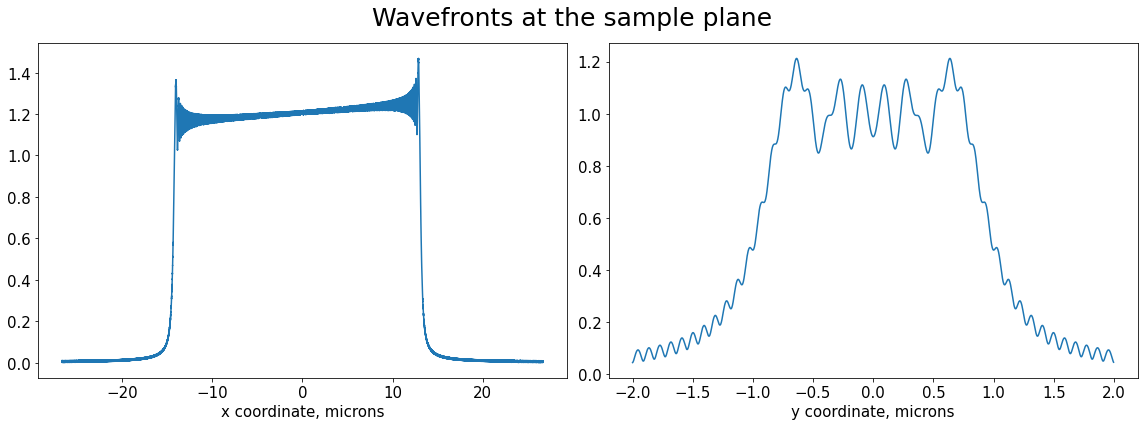

In [15]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx1 * nx_arr, np.abs(defoc_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy1 * ny_arr, np.abs(defoc_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the sample plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/sample_wf.pdf')

In [14]:
x0, x1 = params.beam_span(defocus)
x1 += step_size * n_frames
bar_pos = bar_positions(x0 + offset, x1 - offset, bar_size, bar_rnd)
print(bar_pos, x0, x1)

[-11.45127948 -10.13112104  -9.75586698  -9.34003765  -7.82330296
  -7.28135066  -6.4968159   -6.14412309  -5.7690826   -4.75475724
  -3.93840338  -3.54521382  -2.49711238  -2.40554066  -0.83501108
  -0.23612083  -0.26757337   0.75764151   1.40542822   1.9605078
   3.32959485   3.81394103   4.53360532   4.69673006   5.4588722
   6.23300277   7.60684015   7.68200325   8.63494874   9.25832322
   9.79703673  10.83389074  10.96297711  12.3472939   13.17832475
  13.40604767  13.90361499  14.85261683  15.29198643  16.40121144
  16.74102351  17.20962435  18.42864064  18.85329025  19.71097401
  20.22673976  21.46101933  22.30859581  23.04107801  23.19954816
  24.28042933  24.40699579  25.38447384  25.6122045   27.22018964
  27.74589107  28.41602701  28.74739086  29.17450965  30.22388962
  30.90192186  31.3626904 ] -13.024672559920344 33.64357701935666


In [18]:
smp_pos = params.sample_positions()
x_arr = dx1 * nx_arr + smp_pos[:, None]
b_tr = barcode_profile(bar_pos, x_arr.ravel(), bar_atn, bar_sigma, bulk_atn).reshape(x_arr.shape)
smp_wfx = defoc_wfx * b_tr
print(b_tr.shape, smp_wfx.shape, defoc_wfx.shape)

(200, 58527) (200, 58527) (58527,)


In [19]:
dx2, dy2 = fs_size * pix_size / n_x, ss_size * pix_size / n_y
%time det_wfx = fhf_wp_scan(smp_wfx, dx1, dx2, det_dist, wl)
%time det_wfy = fhf_wp(defoc_wfy, dy1, dy2, det_dist, wl)
print(smp_wfx.shape, det_wfx.shape)

CPU times: user 14.3 s, sys: 648 ms, total: 14.9 s
Wall time: 1.35 s
CPU times: user 5.94 ms, sys: 19 µs, total: 5.96 ms
Wall time: 500 µs
(200, 58527) (200, 58527)


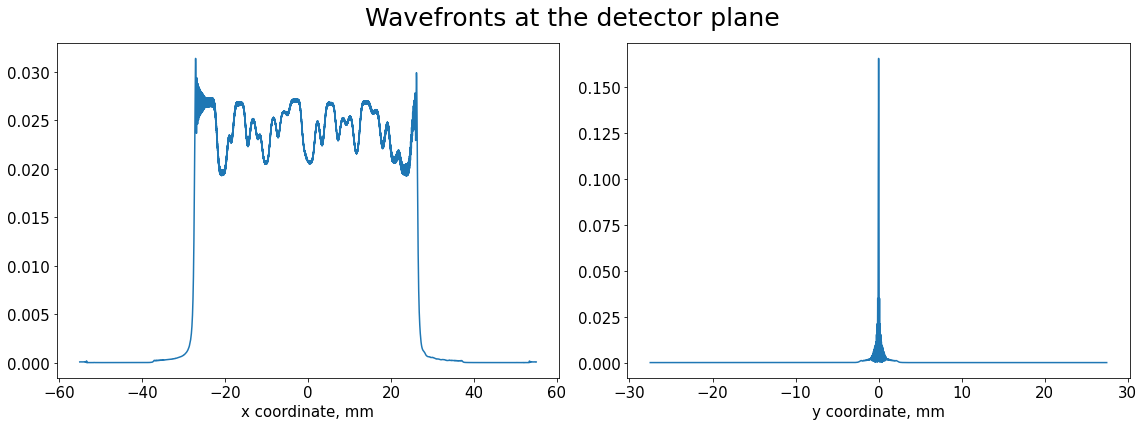

In [20]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.abs(det_wfx[0]))
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.abs(det_wfy))
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_wf.pdf')

In [21]:
from scipy.signal import fftconvolve

sc_x = params.source_curve(defocus + det_dist, dx2)
sc_y = params.source_curve(defocus + det_dist, dy2)
%time det_ix = fft_convolve_scan(np.abs(det_wfx)**2, sc_x)
%time det_iy = fft_convolve(np.abs(det_wfy)**2, sc_y)
print(det_ix.shape, det_iy.shape)

CPU times: user 1.34 s, sys: 77.7 ms, total: 1.42 s
Wall time: 198 ms
CPU times: user 3.18 ms, sys: 645 µs, total: 3.83 ms
Wall time: 433 µs
(200, 58527) (1508,)


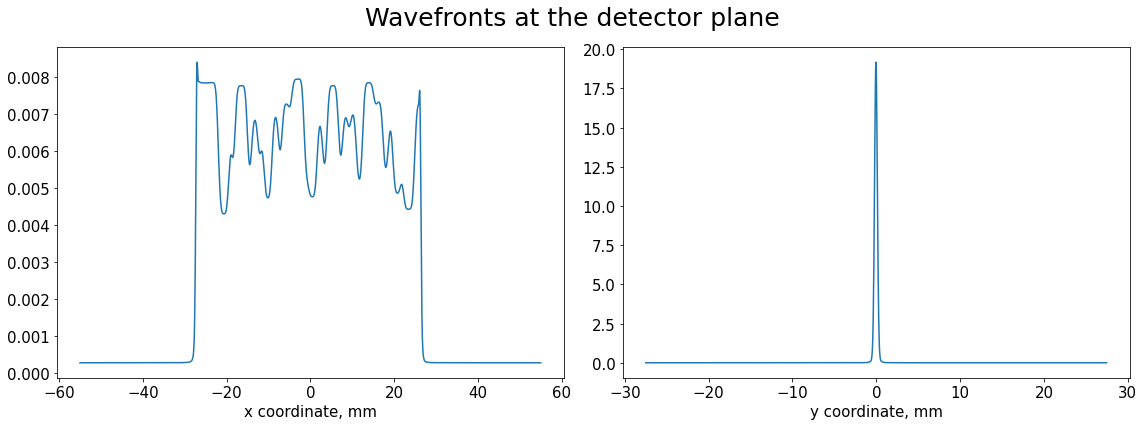

In [22]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.sqrt(p0) / ap_x * det_ix[0] * dx2)
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.sqrt(p0) / ap_y * det_iy * dy2)
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_int.pdf')

In [23]:
%time frames = make_frames(np.sqrt(p0) / ap_x * det_ix, np.sqrt(p0) / ap_y * det_iy, \
                               dx2, dy2, ss_size, fs_size, True)

CPU times: user 10.5 s, sys: 1.42 s, total: 12 s
Wall time: 1.06 s


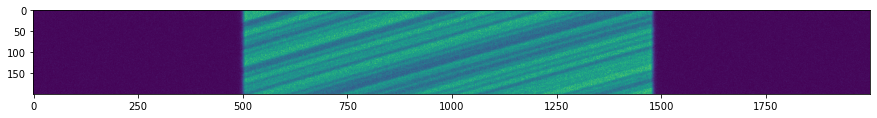

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 6))
ax.imshow(frames.sum(axis=1))
plt.show()

In [19]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

In [20]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [3]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'barcode_profile', 'fft_python', 'gaussian_filter', 'ifft_python', 'irfft_python', 'krig_data', 'least_squares', 'make_reference', 'mse_total', 'np', 'phase_fit', 'pixel_translations', 'rfft_python', 'st', 'st_update', 'str_update', 'update_pixel_map_gs', 'upm_surface']


In [20]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, bar_rnd=0.7, p0 = 5e4, th_s=8e-5,
                           n_frames=200, offset=2.0, defocus=20, alpha=0.03,
                           ab_cnt=0.7)
params.step_size = max(2 * params.ap_x / params.focus * params.defocus,
                       5 * params.bar_size) / params.n_frames
params.offset = 0.7 * params.ap_x / params.focus * params.defocus

st_conv = st_sim.converter()
sim_obj = st_sim.STSim(params)
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

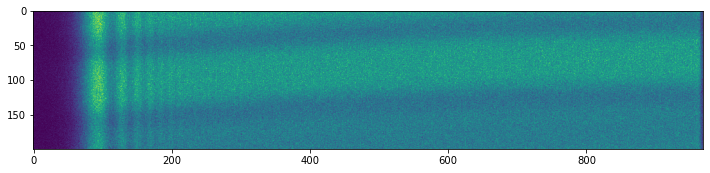

In [21]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

In [6]:
res = dev.st_update(I_n=data.get('data'), dij=data.get('translations'),
                    basis=data.get('basis_vectors'), x_ps=data.x_pixel_size,
                    y_ps=data.y_pixel_size, z=data.distance,
                    df=data.defocus_fs, sw_ss=0, sw_fs=100, ls=.1, n_iter=5, filt=.2)

In [3]:
loader = rst.loader()
data = loader.load('results/test/data.cxi')

In [13]:
st_obj = data.get_st()
st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=10, ls_pm=2.5, verbose=True, n_iter=30, f_tol=-1)

Initial MSE = 0.138479, Initial ls_ri = 10.00
Iteration No. 1: Total MSE = 0.115216, ls_ri = 15.65
Iteration No. 2: Total MSE = 0.098817, ls_ri = 21.05
Iteration No. 3: Total MSE = 0.085845, ls_ri = 26.22
Iteration No. 4: Total MSE = 0.076339, ls_ri = 30.44
Iteration No. 5: Total MSE = 0.070353, ls_ri = 33.17
Iteration No. 6: Total MSE = 0.069995, ls_ri = 33.43
Iteration No. 7: Total MSE = 0.071437, ls_ri = 32.95
Iteration No. 8: Total MSE = 0.070317, ls_ri = 33.58
Iteration No. 9: Total MSE = 0.068131, ls_ri = 34.92
Iteration No. 10: Total MSE = 0.065738, ls_ri = 36.48
Iteration No. 11: Total MSE = 0.063715, ls_ri = 37.85
Iteration No. 12: Total MSE = 0.062238, ls_ri = 38.83
Iteration No. 13: Total MSE = 0.061047, ls_ri = 39.62
Iteration No. 14: Total MSE = 0.060281, ls_ri = 40.17
Iteration No. 15: Total MSE = 0.059755, ls_ri = 40.54
Iteration No. 16: Total MSE = 0.059677, ls_ri = 40.62
Iteration No. 17: Total MSE = 0.059953, ls_ri = 40.50
Iteration No. 18: Total MSE = 0.060180, ls_ri

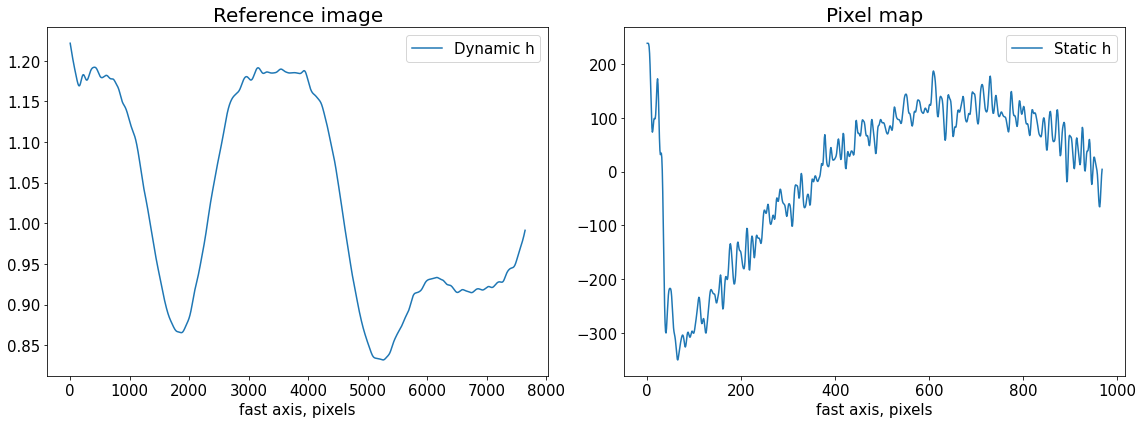

In [14]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0], label='Dynamic h')
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0] - 
             (st_res.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel map', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('fast axis, pixels', fontsize=15)
plt.tight_layout()
plt.show()

In [16]:
st_obj = data.get_st()
st_rgd, extra = st_obj.iter_update_gd(sw_fs=10, ls_pm=2.5, ls_ri=17.0, n_iter=25, verbose=True,
                                      update_translations=False, return_extra=True, learning_rate=1e3,
                                      momentum=0.)

Initial MSE = 0.063408, Initial ls_ri = 17.00
Iteration No. 1: Total MSE = 0.057133, ls_ri = 19.70
Iteration No. 2: Total MSE = 0.048963, ls_ri = 20.19
Iteration No. 3: Total MSE = 0.043525, ls_ri = 20.69
Iteration No. 4: Total MSE = 0.038653, ls_ri = 21.19
Iteration No. 5: Total MSE = 0.034438, ls_ri = 21.70
Iteration No. 6: Total MSE = 0.030667, ls_ri = 22.20
Iteration No. 7: Total MSE = 0.027262, ls_ri = 22.68
Iteration No. 8: Total MSE = 0.024406, ls_ri = 23.15
Iteration No. 9: Total MSE = 0.022136, ls_ri = 23.61
Iteration No. 10: Total MSE = 0.020488, ls_ri = 24.07
Iteration No. 11: Total MSE = 0.019261, ls_ri = 24.54
Iteration No. 12: Total MSE = 0.018249, ls_ri = 24.99
Iteration No. 13: Total MSE = 0.017536, ls_ri = 26.35
Iteration No. 14: Total MSE = 0.016421, ls_ri = 26.74
Iteration No. 15: Total MSE = 0.016052, ls_ri = 27.13
Iteration No. 16: Total MSE = 0.015822, ls_ri = 27.50
Iteration No. 17: Total MSE = 0.015708, ls_ri = 27.88
Iteration No. 18: Total MSE = 0.015682, ls_ri

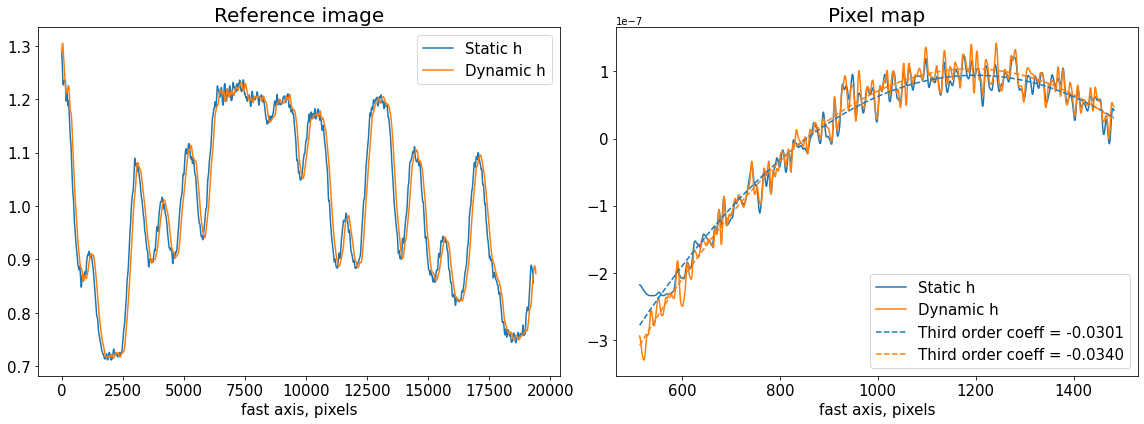

In [45]:
%matplotlib inline
fit_obj = data.update_phase(st_res).get_fit()
fit_ogd = data.update_phase(st_rgd).get_fit()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0], label='Static h')
axes[0].plot(st_rgd.reference_image[0], label='Dynamic h')
axes[1].plot(fit_obj.pixels,
             ref_dx * (st_res.pixel_map - st_obj.pixel_map)[1, 0] - 
             ref_dx * (st_res.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
axes[1].plot(fit_ogd.pixels,
             ref_dx * (st_rgd.pixel_map - st_obj.pixel_map)[1, 0] - 
             ref_dx * (st_rgd.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Dynamic h')
axes[1].plot(fit_obj.pixels, ref_dx * fit_obj.model(fit_obj.fit(loss='linear')['fit']),
             c=mcolors.TABLEAU_COLORS['tab:blue'], linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit_obj.fit(loss='linear')['alpha']))
axes[1].plot(fit_ogd.pixels, ref_dx * fit_obj.model(fit_ogd.fit(loss='linear')['fit']),
             c=mcolors.TABLEAU_COLORS['tab:orange'], linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit_ogd.fit(loss='linear')['alpha']))
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel map', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('fast axis, pixels', fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/dynamic_comparison.pdf')

In [77]:
data = data.update_phase(st_rgd)

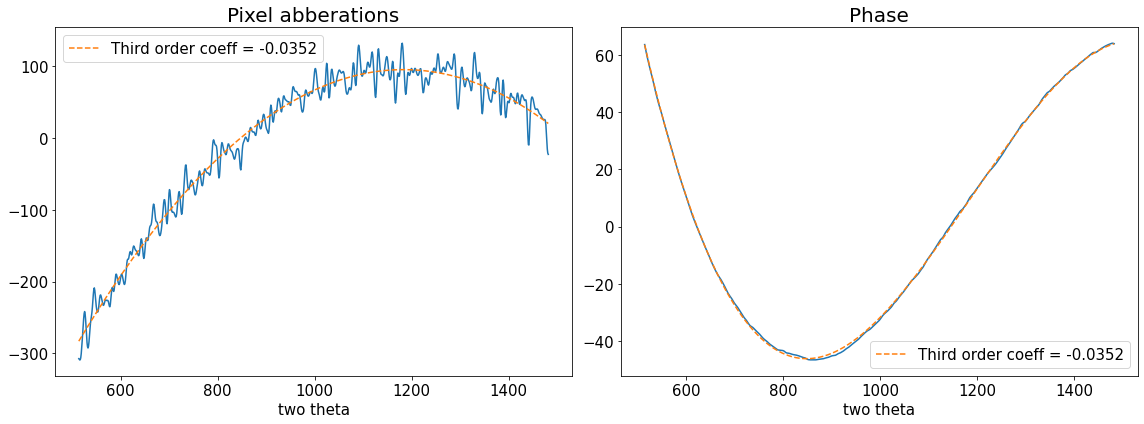

In [78]:
%matplotlib inline
fit_obj = data.get_fit(axis=1)
fit = fit_obj.fit(loss='linear')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_obj.pixels, fit_obj.pixel_abberations)
axes[0].plot(fit_obj.pixels, fit_obj.model(fit['fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[0].set_title('Pixel abberations', fontsize=20)
axes[1].plot(fit_obj.pixels, fit_obj.phase)
axes[1].plot(fit_obj.pixels, fit_obj.model(fit['ph_fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.set_xlabel('two theta', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/1d_sim_fits.png')

In [15]:
protocol = rst.Protocol.import_ini('results/sim_results/protocol.ini')
loader = rst.loader(protocol=protocol)
data = loader.load('results/sim_results/data.cxi')
data = data.crop_data([0, 1, 515, 1470])

In [21]:
st_obj = data.get_st()
st_res = st_obj.iter_update(sw_fs=10, ls_pm=2.5, ls_ri=5, verbose=True, n_iter=10)

Initial MSE = 0.267591
Iteration No. 1: Total MSE = 0.229052
Iteration No. 2: Total MSE = 0.188193
Iteration No. 3: Total MSE = 0.157726
Iteration No. 4: Total MSE = 0.137449
Iteration No. 5: Total MSE = 0.125132
Iteration No. 6: Total MSE = 0.118468
Iteration No. 7: Total MSE = 0.114671
Iteration No. 8: Total MSE = 0.112955
Iteration No. 9: Total MSE = 0.112231
Iteration No. 10: Total MSE = 0.111924


In [24]:
st_obj = data.get_st()
st_res = st_obj.iter_update_gd(sw_fs=8, ls_pm=2.5, ls_ri=50., verbose=True, n_iter=20)

Initial MSE = 0.179852, Initial ls_ri = 50.00
Iteration No. 1: Total MSE = 0.144939, ls_ri = 51.46
Iteration No. 2: Total MSE = 0.113126, ls_ri = 52.37
Iteration No. 3: Total MSE = 0.088769, ls_ri = 52.70
Iteration No. 4: Total MSE = 0.070811, ls_ri = 51.99
Iteration No. 5: Total MSE = 0.058375, ls_ri = 50.74
Iteration No. 6: Total MSE = 0.050156, ls_ri = 48.79
Iteration No. 7: Total MSE = 0.044550, ls_ri = 46.61
Iteration No. 8: Total MSE = 0.040678, ls_ri = 44.36
Iteration No. 9: Total MSE = 0.038191, ls_ri = 42.28
Iteration No. 10: Total MSE = 0.036637, ls_ri = 40.21
Iteration No. 11: Total MSE = 0.035661, ls_ri = 38.12
Iteration No. 12: Total MSE = 0.034942, ls_ri = 36.07
Iteration No. 13: Total MSE = 0.034417, ls_ri = 34.13
Iteration No. 14: Total MSE = 0.034110, ls_ri = 32.35
Iteration No. 15: Total MSE = 0.034038, ls_ri = 30.79
Iteration No. 16: Total MSE = 0.034014, ls_ri = 29.45
Iteration No. 17: Total MSE = 0.034177, ls_ri = 28.35
Iteration No. 18: Total MSE = 0.034302, ls_ri

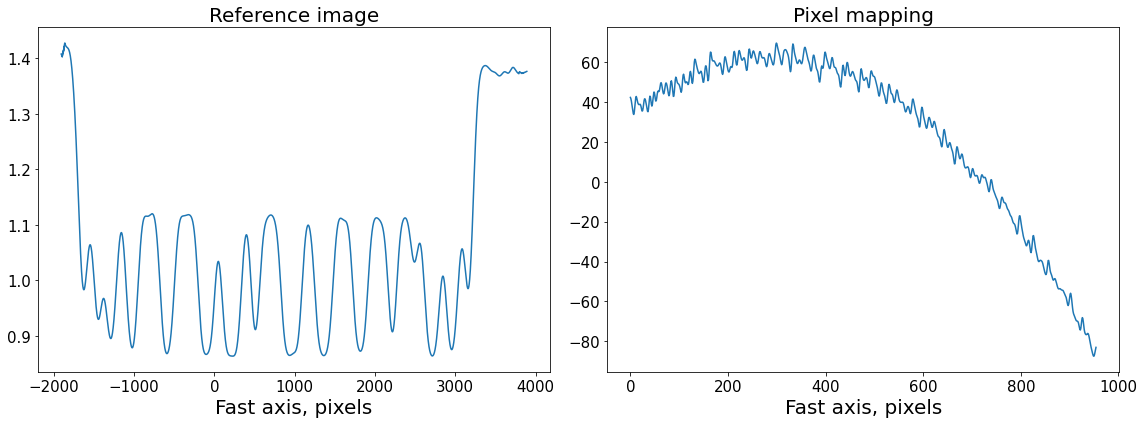

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(np.arange(st_res.reference_image.shape[1]) - st_res.m0,
             st_res.reference_image[0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0])
axes[1].set_title('Pixel mapping', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Fast axis, pixels', fontsize=20)
plt.show()

In [26]:
data.update_phase(st_res)
fit = data.fit_phase(axis=1, max_order=2)
fit['alpha'] # alpha in the simulation

-0.05283627926826833

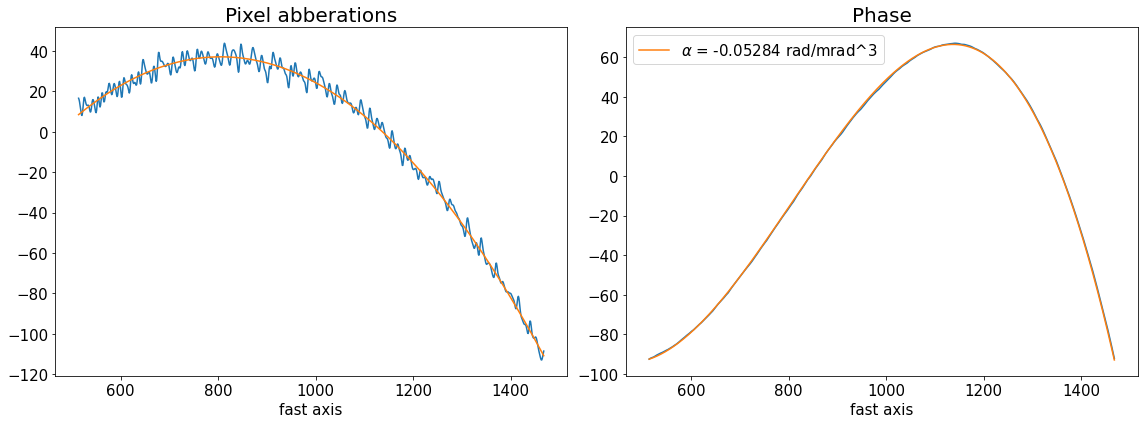

In [33]:
fit_obj = data.get_fit(axis=1)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_obj.pixels, fit_obj.pixel_abberations)
axes[0].plot(fit_obj.pixels, fit_obj.model(fit['fit']))
axes[0].set_title('Pixel abberations', fontsize=20)
axes[1].plot(fit_obj.pixels, fit_obj.phase)
axes[1].plot(fit_obj.pixels, fit_obj.model(fit['ph_fit']),
             label=r'$\alpha$ = {:.5f} rad/mrad^3'.format(fit['alpha']))
axes[1].set_title('Phase', fontsize=20)
axes[1].legend(fontsize=15)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('fast axis', fontsize=15)
plt.show()

In [3]:
data_dir = 'results/test'
with h5py.File(os.path.join(data_dir, 'data.cxi'), 'r') as cxi_file:
    roi = cxi_file['/speckle_tracking/roi'][...]
    I_n = cxi_file['/entry_1/data_1/data'][:, :, roi[2]:roi[3]].sum(axis=1)[:, None]
    M = cxi_file['/speckle_tracking/mask'][roi[0]:roi[1], roi[2]:roi[3]]
    W = cxi_file['/speckle_tracking/whitefield'][roi[0]:roi[1], roi[2]:roi[3]]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translations'][...]
    df = cxi_file['/speckle_tracking/defocus'][...]

di, dj = dev.pixel_translations(basis, dij, df, z)
I_n, W = I_n.astype(np.float64), W.astype(np.float64)
I_n.shape[-1], (dij[0] - dij[1]), basis[0]

(728,
 array([1.e-07, 0.e+00, 0.e+00]),
 array([[ 0.0e+00, -5.5e-05,  0.0e+00],
        [ 5.5e-05,  0.0e+00,  0.0e+00]]))

In [3]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, bar_rnd=0.7, p0 = 5e4, th_s=8e-5,
                           n_frames=200, offset=2.0, defocus=400, alpha=0.05,
                           ab_cnt=0.7)

globals().update(**params.export_dict())
print(params)

{'defocus': 400.0, 'det_dist': 2000000.0, 'n_frames': 200, 'step_size': 0.1, 'step_rnd': 0.2, 'fs_size': 2000, 'pix_size': 55.0, '...': '...'}


In [19]:
st_conv = st_sim.converter()
defoci = np.geomspace(40, 1000, 5)
sim_dict, data_dict = {}, {}

for defocus in defoci:
    key = int(defocus)
    params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                               bulk_atn=0.15, bar_rnd=0.7, p0=5e4, th_s=2.5e-4,
                               n_frames=200, defocus=defocus, alpha=0.03, ab_cnt=0.7)
    params.step_size = max(2 * params.ap_x / params.focus * params.defocus,
                           5 * params.bar_size) / params.n_frames
    params.offset = 0.7 * params.ap_x / params.focus * params.defocus
    sim_dict[key] = st_sim.STSim(params=params)
    data_dict[key] = st_conv.export_data(sim_dict[key].ptychograph(), sim_dict[key])

    st_obj = data_dict[key].get_st()
    st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=20, ls_pm=2.5, return_extra=False)
    data_dict[key] = data_dict[key].update_phase(st_res)
    
print([(key, data.fit_phase()['alpha']) for key, data in data_dict.items()])

[(40, -0.024653393240160783), (89, -0.03139072248107814), (200, -0.023946268809463423), (447, -0.029978493588203352), (1000, -0.027917207849566368)]


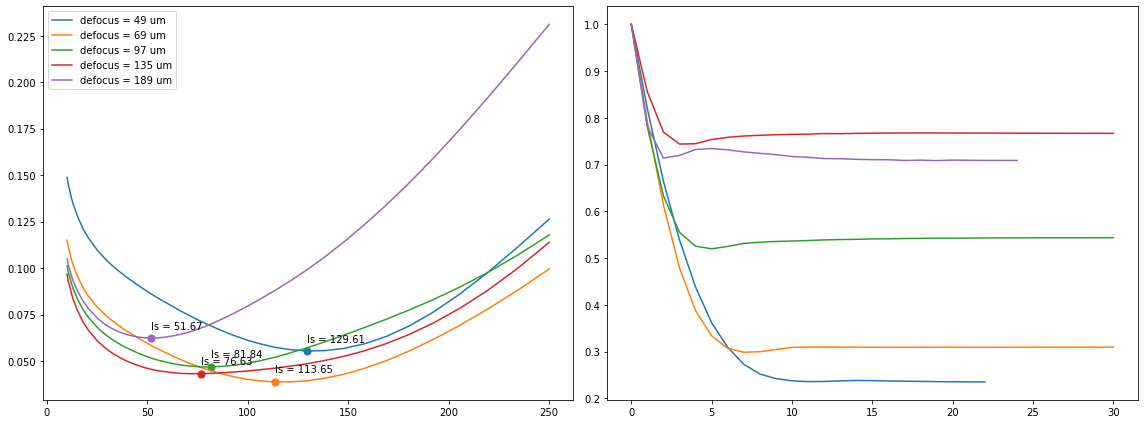

In [36]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for key, color in zip(sorted(data_dict)[:5], mcolors.TABLEAU_COLORS):
    axes[0].plot(lss_ri, mse_ind[key], label='defocus = {:d} um'.format(key))
    axes[0].scatter(lss_ri[np.argmin(mse_ind[key])], np.min(mse_ind[key]), s=50)
    axes[0].text(lss_ri[np.argmin(mse_ind[key])] + 0.01, np.min(mse_ind[key]) + 0.005,
            s='ls = {:.2f}'.format(lss_ri[np.argmin(mse_ind[key])]))
    axes[1].plot(err_dict[key] / err_dict[key][0], linestyle='solid', color=color)
axes[0].legend()
plt.tight_layout()
plt.show()
# plt.savefig('figures/dynamic_update.pdf')

In [17]:
st_conv = st_sim.converter()
out_path = 'results/defocus/defocus_alpha_30/defocus_{:d}um'
for key in data_dict:
    st_conv.save_sim(data_dict[key].data, sim_dict[key], out_path.format(key))
    with h5py.File(os.path.join(out_path.format(key), 'data.cxi'), 'r+') as cxi_file:
        data_dict[key].write_cxi(cxi_file)

In [22]:
print(sorted(data_dict))

[40, 89, 200, 447, 1000]


In [23]:
key = 1000
data = data_dict[key]

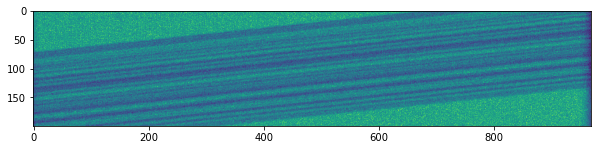

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

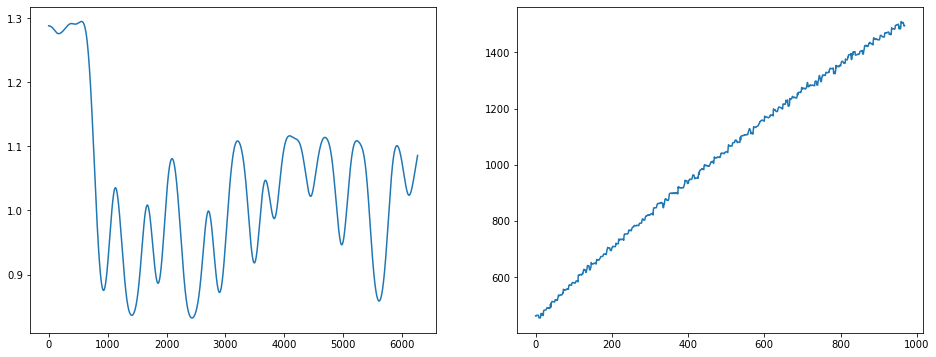

In [10]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0])
axes[1].plot(st_res.pixel_map[1, 0])
plt.show()

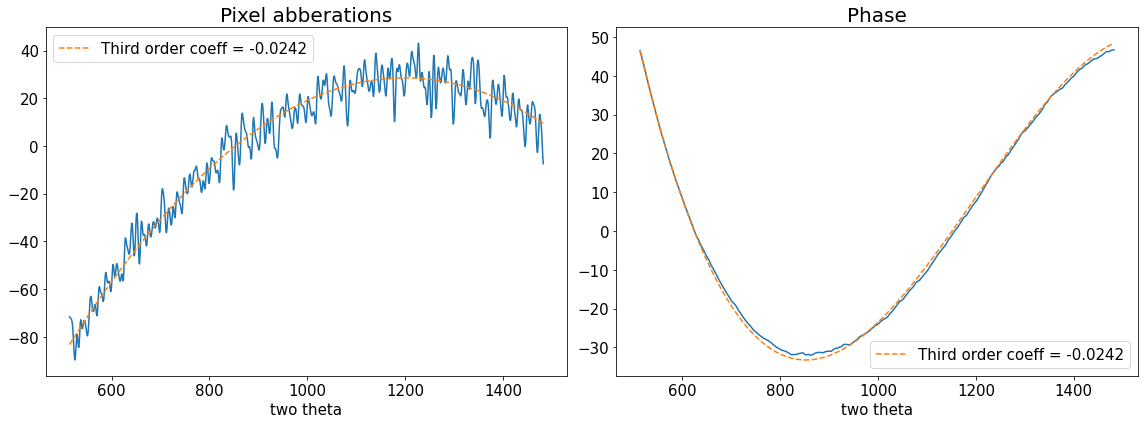

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fit = fit_obj.fit()
axes[0].plot(fit_obj.pixels, fit_obj.pixel_abberations)
axes[0].plot(fit_obj.pixels, fit_obj.model(fit['fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[0].set_title('Pixel abberations', fontsize=20)
axes[1].plot(fit_obj.pixels, fit_obj.phase)
axes[1].plot(fit_obj.pixels, fit_obj.model(fit['ph_fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.set_xlabel('two theta', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

# Experiment results

In [3]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1100), 2165: (0, 1, 430, 1140),
            2188: (0, 1, 365, 1155), 2202: (0, 1, 275, 1100), 2274: (0, 1, 430, 1140), 2291: (0, 1, 430, 1140),
            2311: (0, 1, 440, 1220), 2312: (0, 1, 440, 1220), 2313: (0, 1, 430, 1220)}
data_path = 'results/exp/Scan_{:d}.cxi'
scan_num = 2312

loader = rst.loader()
st_data = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num])
st_data = st_data.make_whitefield()
st_data = st_data.make_pixel_map()

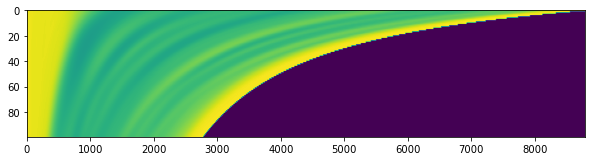

In [9]:
df_arr = np.linspace(5e-5, 2e-4, 100)
grad, sweep_img = st_data.defocus_sweep(df_arr, ls_ri=25)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(sweep_img[:, 0])
ax.set_aspect(20)
plt.show()

In [11]:
st_res = dev.st_update(I_n=st_data.get('data'), dij=st_data.get('translations'),
                       basis=st_data.get('basis_vectors'), x_ps=st_data.x_pixel_size,
                       y_ps=st_data.y_pixel_size, z=st_data.distance,
                       df=st_data.defocus_fs, sw_ss=0, sw_fs=50, ls=.1, n_iter=5, filt=2.5)

In [31]:
st_data = st_data.update_defocus(defocus_fs=df_arr[np.argmin(ds_scan)])
st_obj = st_data.get_st()
st_res, errors = st_obj.iter_update(sw_fs=5, ls_pm=2.5, ls_ri=1e-1, n_iter=10, verbose=True,
                                    return_errors=True, f_tol=-10.)

Initial MSE = 0.434612
Iteration No. 1: Total MSE = 0.435052
Iteration No. 2: Total MSE = 0.465146
Iteration No. 3: Total MSE = 0.416128
Iteration No. 4: Total MSE = 0.336057
Iteration No. 5: Total MSE = 0.330573
Iteration No. 6: Total MSE = 0.337387
Iteration No. 7: Total MSE = 0.350018
Iteration No. 8: Total MSE = 0.348236
Iteration No. 9: Total MSE = 0.332349
Iteration No. 10: Total MSE = 0.345568


In [24]:
st_obj = st_data.get_st()
st_rgd, extra = st_obj.iter_update_gd(sw_fs=15, ls_pm=2.5, ls_ri=25.0, n_iter=20, verbose=True,
                                      return_extra=True, learning_rate=1e3, momentum=0.)

Initial MSE = 0.039888, Initial ls_ri = 25.00
Iteration No. 1: Total MSE = 0.023308, ls_ri = 25.52
Iteration No. 2: Total MSE = 0.014168, ls_ri = 25.58
Iteration No. 3: Total MSE = 0.009842, ls_ri = 25.62
Iteration No. 4: Total MSE = 0.007963, ls_ri = 25.67
Iteration No. 5: Total MSE = 0.007558, ls_ri = 25.71
Iteration No. 6: Total MSE = 0.007596, ls_ri = 25.75


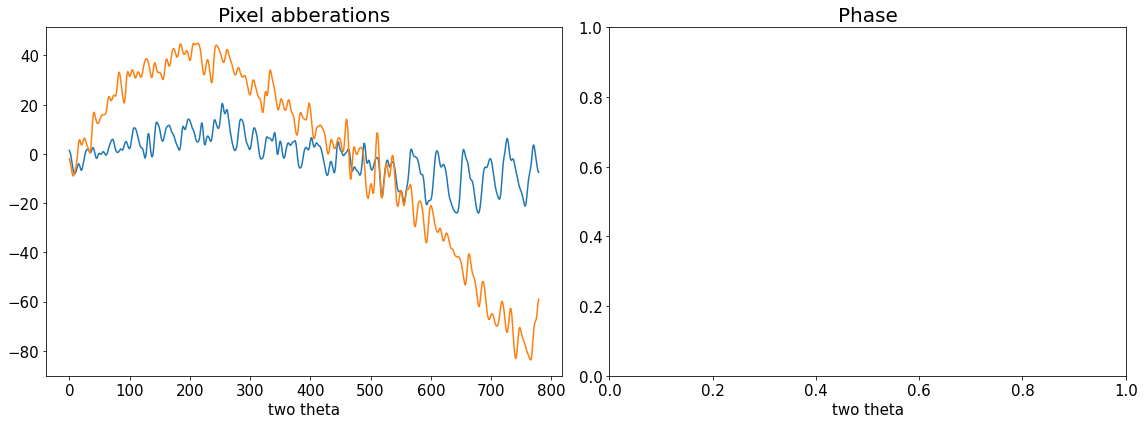

In [36]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot((st_res['u'] - np.indices(st_obj.whitefield.shape))[1, 0])
axes[0].plot((st_rgd.pixel_map - st_obj.pixel_map)[1, 0])
axes[0].set_title('Pixel abberations', fontsize=20)
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.set_xlabel('two theta', fontsize=15)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()

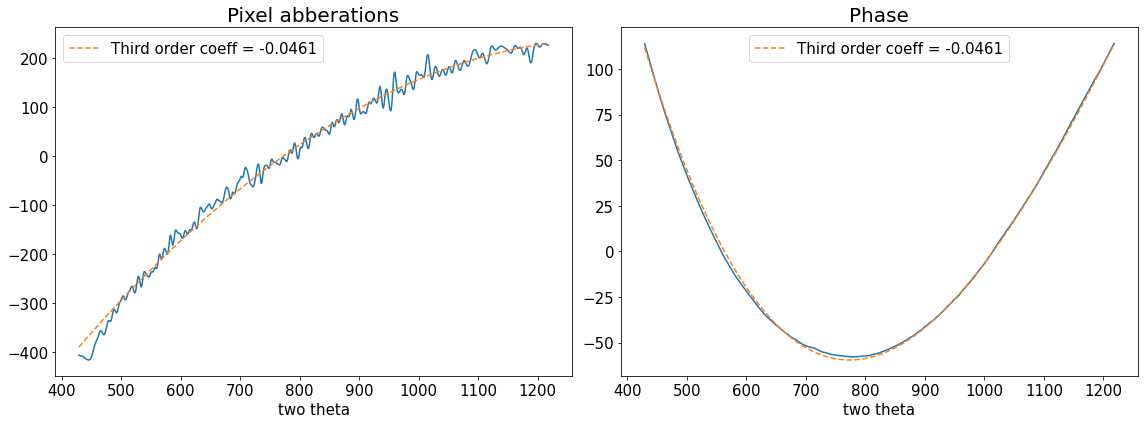

In [14]:
%matplotlib inline
fit_obj = st_data.get_fit(axis=1)
fit = fit_obj.fit()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_obj.pixels, fit_obj.pixel_abberations)
axes[0].plot(fit_obj.pixels, fit_obj.model(fit['fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[0].set_title('Pixel abberations', fontsize=20)
axes[1].plot(fit_obj.pixels, fit_obj.phase)
axes[1].plot(fit_obj.pixels, fit_obj.model(fit['ph_fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.set_xlabel('two theta', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/1d_sim_fits.png')

In [26]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1200)}
filename = 'Scan_{:d}.cxi'
exp_dir = 'results/exp'
scan_num = 2008

with h5py.File(os.path.join(exp_dir, filename.format(scan_num)), 'r') as cxi_file:
    roi = roi_dict[scan_num]
    I_n = cxi_file['/entry_1/data_1/data'][:, roi[0]:roi[1], roi[2]:roi[3]].sum(axis=1)[:, None]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translation'][...]

df = 1e-4
I_n = I_n.astype(np.float64)
M = np.ones((I_n.shape[1], I_n.shape[2]), dtype=bool)
W = make_whitefield(I_n, M)
(dij[1] - dij[0]), I_n.shape[-1], np.mean(I_n), basis[0]

(array([0.0e+00, 9.6e-08, 0.0e+00]),
 850,
 72.90818870122307,
 array([[-5.5e-05,  0.0e+00,  0.0e+00],
        [ 0.0e+00, -5.5e-05,  0.0e+00]]))